In [24]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [26]:
# Cell 2: Load dataset
# Load the dataset
file_path = 'D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_modified.csv'
df = pd.read_csv(file_path)
# Replace 'your_dataset.csv' with the path to your dataset
# df = pd.read_csv('your_dataset.csv')
# Display the first few rows to understand the data
df.head()
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        1000 non-null   object
 1   TransactionType   1000 non-null   object
 2   EngagementLevel   1000 non-null   object
 3   RFM_Score         1000 non-null   int64 
 4   Income            1000 non-null   int64 
 5   Age               1000 non-null   int64 
 6   CreditScore       1000 non-null   int64 
 7   Mortgage          1000 non-null   int64 
 8   Personal_Loan     1000 non-null   int64 
 9   Credit_Card       1000 non-null   int64 
 10  Exited            1000 non-null   int64 
 11  TransactionYear   1000 non-null   int64 
 12  TransactionMonth  1000 non-null   int64 
 13  TransactionDay    1000 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 109.5+ KB


<Figure size 1500x1000 with 0 Axes>

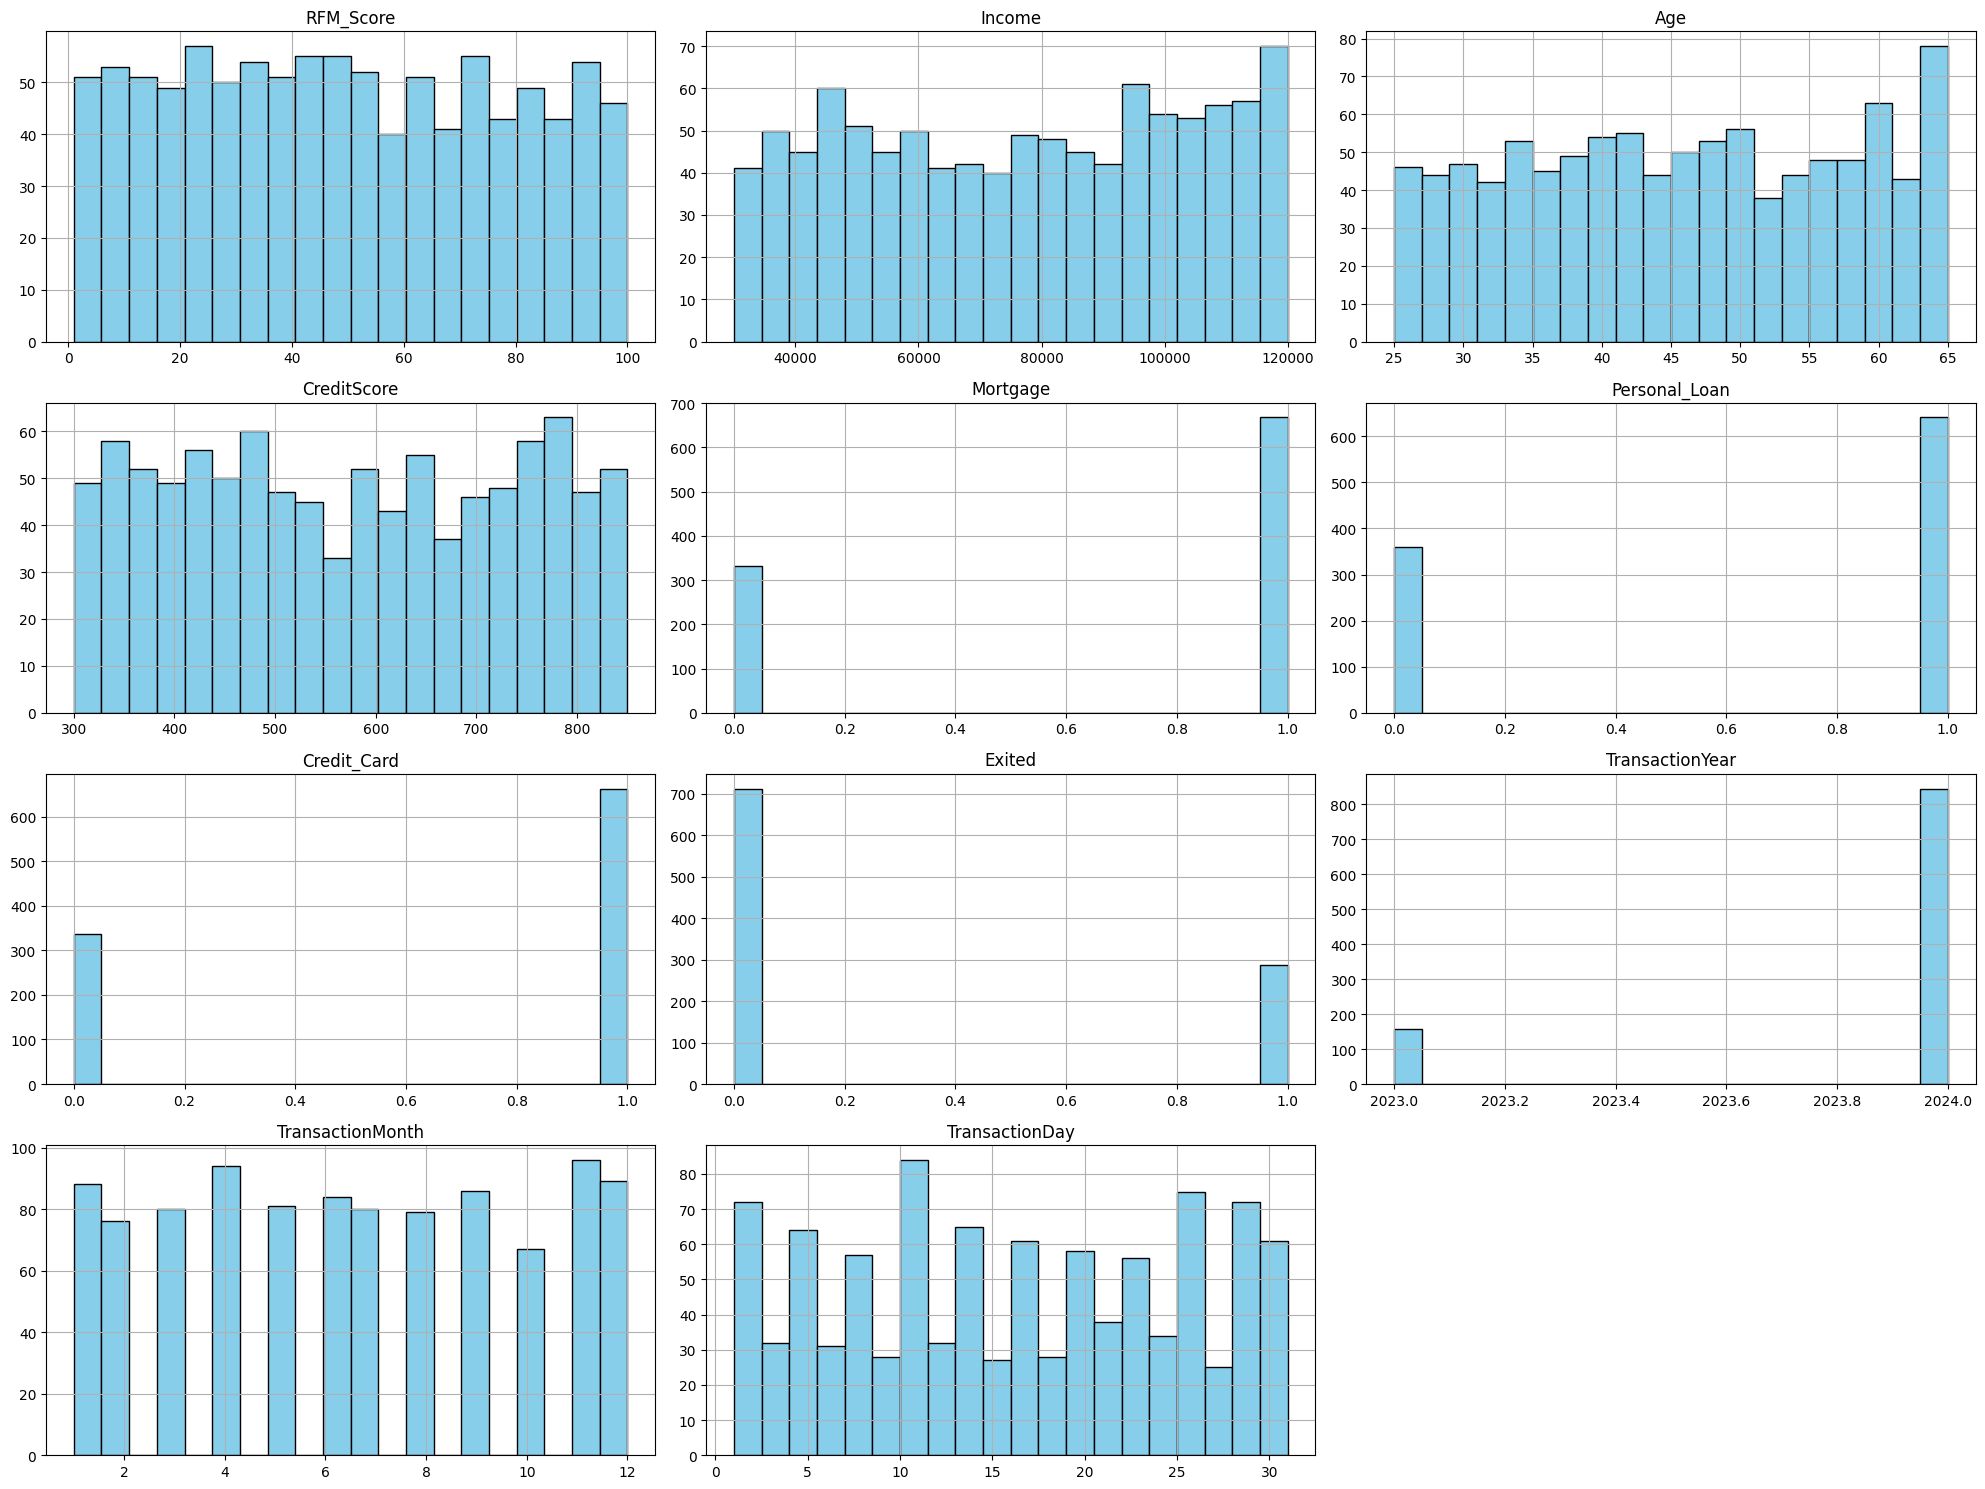

In [27]:
# Cell 3: Data Cleaning function
def clean_data(df):
    # Drop duplicates
    df = df.drop_duplicates()
    
    # Handle missing values
    df = df.fillna(df.median(numeric_only=True))  # Fill numeric columns with median
    df = df.fillna(df.mode().iloc[0])             # Fill categorical columns with mode
    
    # Remove columns with high missing values (e.g., >50%)
    threshold = 0.5
    df = df[df.columns[df.isnull().mean() < threshold]]
    
    return df

# Apply data cleaning
df = clean_data(df)
df.head()  # View the cleaned data

plt.figure(figsize=(15, 10))
df.hist(bins=20, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()


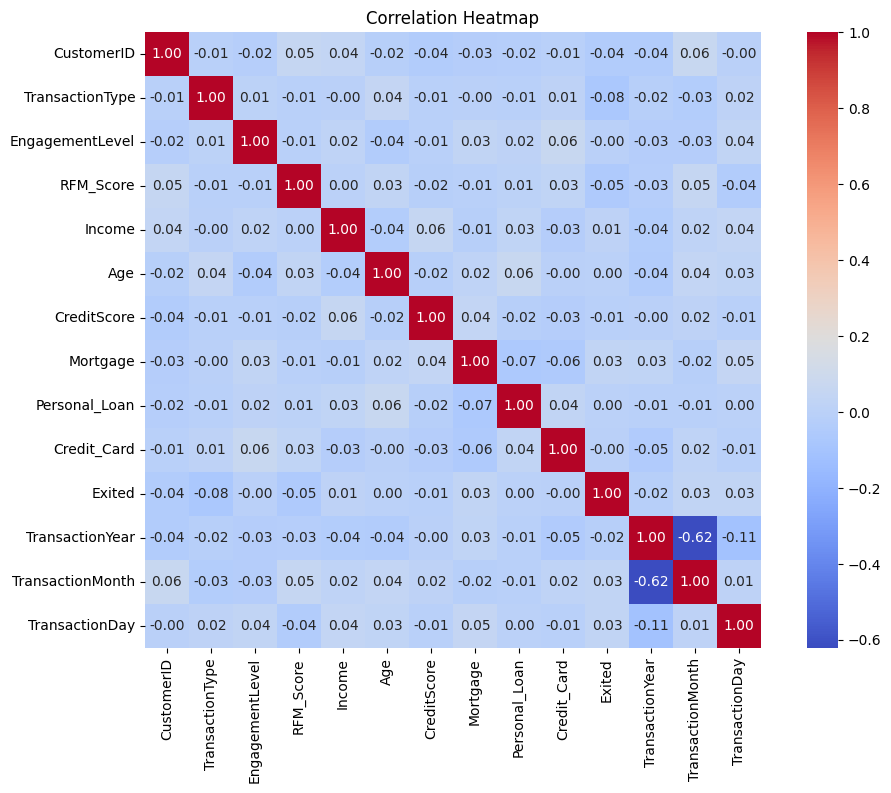

In [28]:
# Cell 4: Feature Engineering function
def feature_engineering(df):
    # Encoding categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    return df

# Apply feature engineering
df = feature_engineering(df)
df.head()  # View the transformed data

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.show()


In [11]:
# Cell 5: Prepare Multi-Label Target Variables
# Define product columns as target columns for multi-label classification
target_columns = ['Mortgage', 'Personal_Loan', 'Credit_Card']

# Separate features and targets
X = df.drop(columns=target_columns)
y = df[target_columns]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Cell 6: Standardize Data function
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# Standardize the data
X_train, X_test = standardize_data(X_train, X_test)


In [15]:
# Cell 7: Model Training function for Multi-Label Classification
def train_multi_label_model(X_train, y_train):
    # Initialize LightGBM model
    model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)
    
    # Use MultiOutputClassifier to handle multiple targets
    multi_label_model = MultiOutputClassifier(model)
    multi_label_model.fit(X_train, y_train)
    
    return multi_label_model

# Train the model
multi_label_model = train_multi_label_model(X_train, y_train)


[LightGBM] [Info] Number of positive: 541, number of negative: 259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676250 -> initscore=0.736591
[LightGBM] [Info] Start training from score 0.736591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [16]:
# Cell 8: Model Evaluation function for Multi-Label Classification
def evaluate_multi_label_model(model, X_test, y_test, target_columns):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate evaluation metrics for each label
    for i, column in enumerate(target_columns):
        print(f"\nEvaluation for {column}:")
        
        # Extract probabilities for the current target
        y_test_column = y_test[column]
        y_pred_column = y_pred[:, i]
        y_pred_proba_column = y_pred_proba[i][:, 1]  # Probability of positive class
        
        # Metrics
        roc_auc = roc_auc_score(y_test_column, y_pred_proba_column)
        avg_precision = average_precision_score(y_test_column, y_pred_proba_column)
        print(f"ROC AUC Score: {roc_auc}")
        print(f"Average Precision Score: {avg_precision}")
        print("\nClassification Report:\n", classification_report(y_test_column, y_pred_column))

# Evaluate the model
evaluate_multi_label_model(multi_label_model, X_test, y_test, target_columns)



Evaluation for Mortgage:
ROC AUC Score: 0.48635530147772627
Average Precision Score: 0.6265973358549171

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.16      0.22        73
           1       0.63      0.83      0.72       127

    accuracy                           0.58       200
   macro avg       0.49      0.50      0.47       200
weighted avg       0.53      0.58      0.54       200


Evaluation for Personal_Loan:
ROC AUC Score: 0.4841452205882353
Average Precision Score: 0.6670375863943981

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.22      0.26        64
           1       0.68      0.77      0.72       136

    accuracy                           0.59       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.56      0.59      0.57       200


Evaluation for Credit_Card:
ROC AUC Score: 0.43212744772651845
Average Precision 

In [20]:
# Cell 9: Testing on Unseen Data for Multi-Label Classification
def test_unseen_data_multi_label(model, unseen_df, target_columns):
    # Perform similar cleaning and feature engineering as the training set
    unseen_df = clean_data(unseen_df)
    unseen_df = feature_engineering(unseen_df)
    
    # Drop target columns if they exist in unseen data
    unseen_X = unseen_df.drop(columns=target_columns, errors='ignore')
    
    # Standardize the unseen data
    scaler = StandardScaler()
    unseen_X = scaler.fit_transform(unseen_X)
    
    # Make predictions on unseen data
    predictions = model.predict(unseen_X)
    predictions_proba = [prob[:, 1] for prob in model.predict_proba(unseen_X)]
    
    # Convert predictions to DataFrame for readability
    pred_df = pd.DataFrame(predictions, columns=target_columns)
    pred_proba_df = pd.DataFrame(predictions_proba, columns=target_columns).T
    pred_df['Prediction_Probability'] = pred_proba_df.max(axis=0)  # Adding probability for each product
    
    return pred_df






Evaluation for Mortgage:
ROC AUC Score: 0.49
Average Precision Score: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.16      0.22        73
           1       0.63      0.83      0.72       127

    accuracy                           0.58       200
   macro avg       0.49      0.50      0.47       200
weighted avg       0.53      0.58      0.54       200



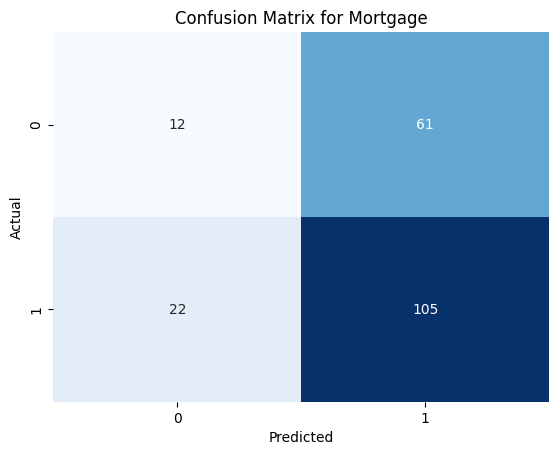


Evaluation for Personal_Loan:
ROC AUC Score: 0.48
Average Precision Score: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.22      0.26        64
           1       0.68      0.77      0.72       136

    accuracy                           0.59       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.56      0.59      0.57       200



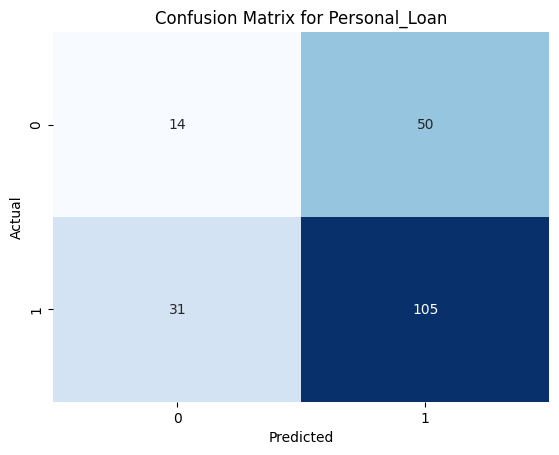


Evaluation for Credit_Card:
ROC AUC Score: 0.43
Average Precision Score: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.12      0.16        69
           1       0.63      0.81      0.71       131

    accuracy                           0.57       200
   macro avg       0.44      0.46      0.43       200
weighted avg       0.50      0.57      0.52       200



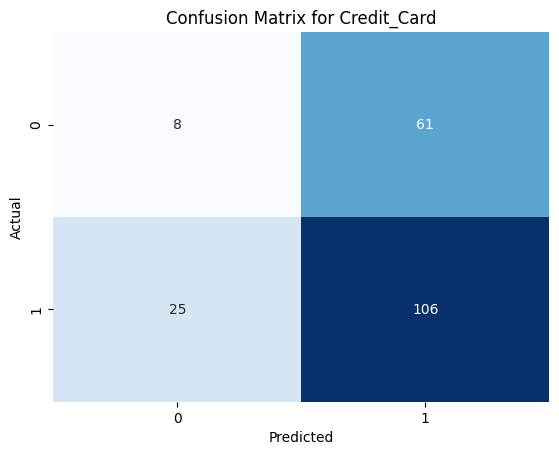

In [29]:
# Cell 10: Model Evaluation - ROC AUC, Precision, and Confusion Matrix for each label
def evaluate_multi_label_model(model, X_test, y_test, target_columns):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    for i, column in enumerate(target_columns):
        print(f"\nEvaluation for {column}:")
        
        y_test_column = y_test[column]
        y_pred_column = y_pred[:, i]
        y_pred_proba_column = y_pred_proba[i][:, 1]  # Probability of positive class
        
        # Metrics
        roc_auc = roc_auc_score(y_test_column, y_pred_proba_column)
        avg_precision = average_precision_score(y_test_column, y_pred_proba_column)
        print(f"ROC AUC Score: {roc_auc:.2f}")
        print(f"Average Precision Score: {avg_precision:.2f}")
        print("\nClassification Report:\n", classification_report(y_test_column, y_pred_column))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test_column, y_pred_column)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {column}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

evaluate_multi_label_model(multi_label_model, X_test, y_test, target_columns)



Evaluation for Mortgage:
ROC AUC Score: 0.49
Average Precision Score: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.16      0.22        73
           1       0.63      0.83      0.72       127

    accuracy                           0.58       200
   macro avg       0.49      0.50      0.47       200
weighted avg       0.53      0.58      0.54       200



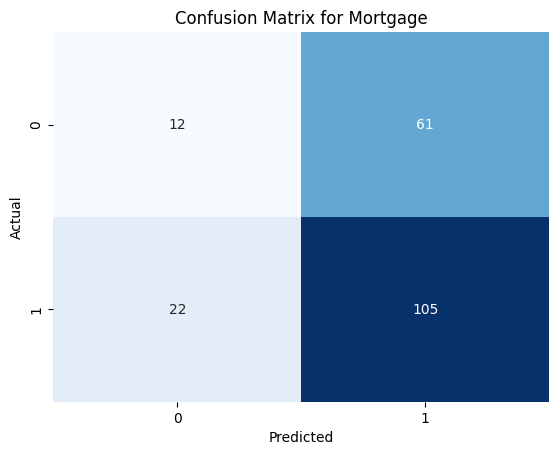


Evaluation for Personal_Loan:
ROC AUC Score: 0.48
Average Precision Score: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.22      0.26        64
           1       0.68      0.77      0.72       136

    accuracy                           0.59       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.56      0.59      0.57       200



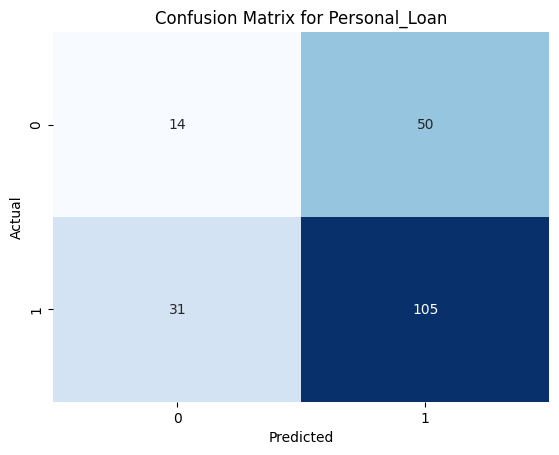


Evaluation for Credit_Card:
ROC AUC Score: 0.43
Average Precision Score: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.12      0.16        69
           1       0.63      0.81      0.71       131

    accuracy                           0.57       200
   macro avg       0.44      0.46      0.43       200
weighted avg       0.50      0.57      0.52       200



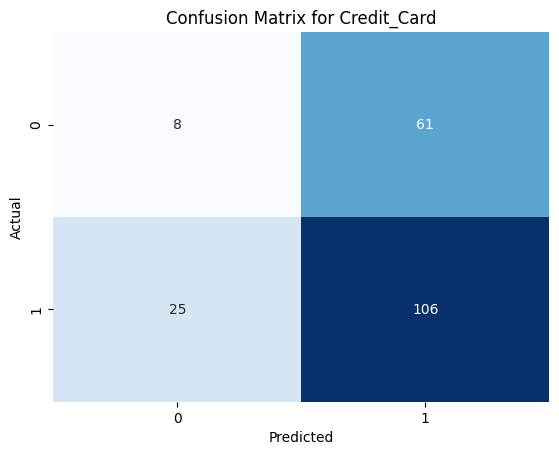

In [30]:
# Cell 10: Model Evaluation - ROC AUC, Precision, and Confusion Matrix for each label
def evaluate_multi_label_model(model, X_test, y_test, target_columns):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    for i, column in enumerate(target_columns):
        print(f"\nEvaluation for {column}:")
        
        y_test_column = y_test[column]
        y_pred_column = y_pred[:, i]
        y_pred_proba_column = y_pred_proba[i][:, 1]  # Probability of positive class
        
        # Metrics
        roc_auc = roc_auc_score(y_test_column, y_pred_proba_column)
        avg_precision = average_precision_score(y_test_column, y_pred_proba_column)
        print(f"ROC AUC Score: {roc_auc:.2f}")
        print(f"Average Precision Score: {avg_precision:.2f}")
        print("\nClassification Report:\n", classification_report(y_test_column, y_pred_column))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test_column, y_pred_column)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {column}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

evaluate_multi_label_model(multi_label_model, X_test, y_test, target_columns)


In [31]:
# Cell 11: Simulate Unseen Data and Generate Predictions with Cross-Sell/Upsell Recommendations
# Select a subset of X_test (without the target columns) to simulate unseen data
unseen_df = pd.DataFrame(X_test, columns=X.columns)  # Use X_test data as unseen data

# Make predictions on the simulated unseen data
predictions = multi_label_model.predict(unseen_df)
predictions_proba = multi_label_model.predict_proba(unseen_df)

# Process predictions and probabilities into a DataFrame
pred_df = pd.DataFrame(predictions, columns=target_columns)

# Add probabilities to the DataFrame
for i, column in enumerate(target_columns):
    pred_df[f'{column}_Probability'] = [proba[1] for proba in predictions_proba[i]]

# Define a threshold for cross-sell and upsell recommendation
threshold = 0.6  # You can adjust this value based on your preference

# Function to print recommended products for each input
def print_recommendations(pred_df):
    for idx, row in pred_df.iterrows():
        recommended_products = []
        for product in target_columns:
            if row[f'{product}_Probability'] >= threshold:
                recommended_products.append(product)
        if recommended_products:
            print(f"Customer {idx + 1}: Recommended for Cross-Sell/Upsell -> {', '.join(recommended_products)}")
        else:
            print(f"Customer {idx + 1}: No Cross-Sell/Upsell recommendation")

# Display the recommendations
print_recommendations(pred_df)


Customer 1: Recommended for Cross-Sell/Upsell -> Personal_Loan
Customer 2: Recommended for Cross-Sell/Upsell -> Mortgage
Customer 3: Recommended for Cross-Sell/Upsell -> Mortgage
Customer 4: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan, Credit_Card
Customer 5: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan
Customer 6: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan
Customer 7: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan, Credit_Card
Customer 8: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan, Credit_Card
Customer 9: Recommended for Cross-Sell/Upsell -> Mortgage
Customer 10: Recommended for Cross-Sell/Upsell -> Mortgage, Credit_Card
Customer 11: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan, Credit_Card
Customer 12: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan
Customer 13: Recommended for Cross-Sell/Upsell -> Mortgage, Personal_Loan, Credit_Card
Customer 14: Recommended for Cross-Sell